In [ ]:
from google.colab import files
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


# Upload kaggle.json
uploaded = files.upload()

# Move kaggle.json to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle
!pip install kaggle --quiet

# Dataset directory after unzipping
dataset_dir = "chest_xray_data/chest_xray"

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the dataset
!unzip chest-xray-pneumonia.zip -d chest_xray_data

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
       tf.keras.layers.RandomFlip("horizontal_and_vertical"),
       tf.keras.layers.RandomRotation(0.2),
       tf.keras.layers.RandomZoom(0.2),
       tf.keras.layers.RandomContrast(0.2),
       # Add more augmentation layers, especially for the Normal class
       # Example:
       tf.keras.layers.RandomBrightness(0.2),  # Adjust brightness
       tf.keras.layers.GaussianNoise(0.1),     # Add Gaussian noise
   ])

   # Modify normalize_data to apply augmentation only to Normal class:
def normalize_data(image, label):
    image = image / 255.0
    if label == 0:  # Normal class
        image = data_augmentation(image)  # Apply augmentations
    return image, label

# Load datasets using image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    f"{dataset_dir}/train",
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'  # Pneumonia vs. Normal
)

validation_dataset = image_dataset_from_directory(
    f"{dataset_dir}/val",
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
)

test_dataset = image_dataset_from_directory(
    f"{dataset_dir}/test",
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
)

# Normalize pixel values to the range [0, 1]
def normalize_data(image, label):
    image = image / 255.0
    return image, label

train_dataset = train_dataset.map(normalize_data)
validation_dataset = validation_dataset.map(normalize_data)
test_dataset = test_dataset.map(normalize_data)

# Optimize performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Compute class weights
true_labels = np.concatenate([y.numpy() for x, y in train_dataset], axis=0)  # Convert tensors to NumPy arrays
true_labels = true_labels.flatten() # Flatten to 1D
class_weights = compute_class_weight('balanced', classes=np.unique(true_labels), y=true_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Adjust weight class manually
class_weight_dict = {0: 30.0, 1: 1.0}  # Increasing weight for Normal class


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace chest_xray_data/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define CNN model with regularization (Dropout + L2 Regularization)
model = Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),  # Define input explicitly
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Dropout

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Dropout

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Dropout

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    BatchNormalization(),
    Dropout(0.2),  # Dropout
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate for fine-grained learning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,          # Factor by which the learning rate will be reduced
    patience=6,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.0001        # Lower bound on the learning rate
)

# Train the model with regularization (Dropout + L2)
history_with_reg = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,  # Use more epochs for better results
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict  # Add class weights here
)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.7915 - loss: 5.0996 - val_accuracy: 0.5000 - val_loss: 5.5713 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8759 - loss: 4.0227 - val_accuracy: 0.5000 - val_loss: 4.6364 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8905 - loss: 3.6748 - val_accuracy: 0.5000 - val_loss: 4.0921 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9256 - loss: 3.3550 - val_accuracy: 0.8750 - val_loss: 3.2536 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9262 - loss: 3.1647 - val_accuracy: 0.8750 - val_loss: 3.1388 - learning_rate: 1.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9477 - loss: 2.9250 - val_accuracy: 0.8750 - val_loss: 2.8391 - learning_rate: 1.0000e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - ac

In [ ]:
# Define CNN model without regularization
model_no_reg = Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_no_reg.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Train the model without regularization
history_no_reg = model_no_reg.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,  # Use fewer epochs for comparison
    class_weight=class_weight_dict  # Add class weights here
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5588 - loss: 1.7453 - val_accuracy: 0.7500 - val_loss: 0.4501
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8396 - loss: 0.5827 - val_accuracy: 0.9375 - val_loss: 0.3300
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8843 - loss: 0.5338 - val_accuracy: 0.8750 - val_loss: 0.2952
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9095 - loss: 0.4014 - val_accuracy: 0.9375 - val_loss: 0.1352
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9574 - loss: 0.2238 - val_accuracy: 0.8125 - val_loss: 0.6263
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9423 - loss: 0.2678 - val_accuracy: 0.8750 - val_loss: 0.2813
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9591 - loss: 0.1938 - val_accuracy: 0.9375 - val_loss: 0.1470
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9736 - loss: 0.1435 - val_accu

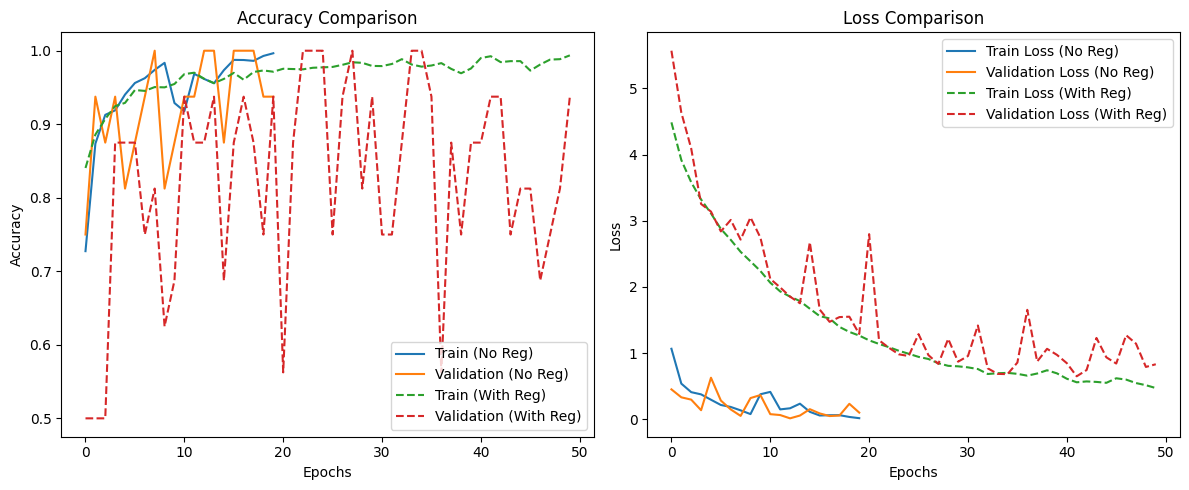

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.8615 - loss: 0.9657
Test Loss: 0.9413737058639526
Test Accuracy: 0.8733974099159241
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.81      0.85       234
   Pneumonia       0.89      0.94      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624


Confusion Matrix:
[[189  45]
 [ 24 366]]


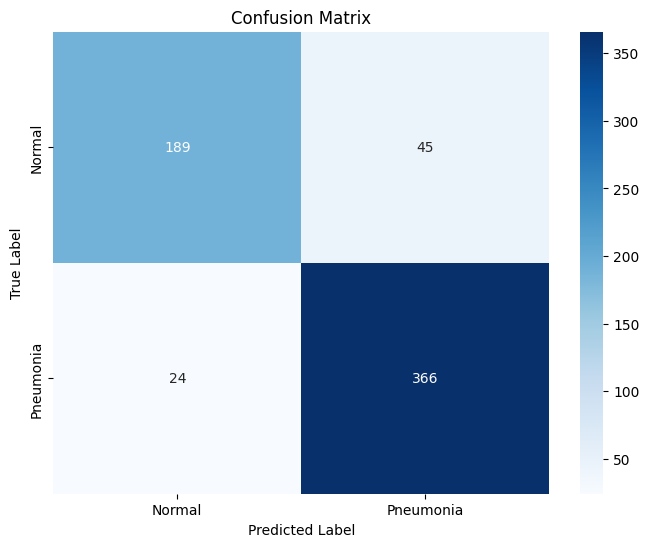

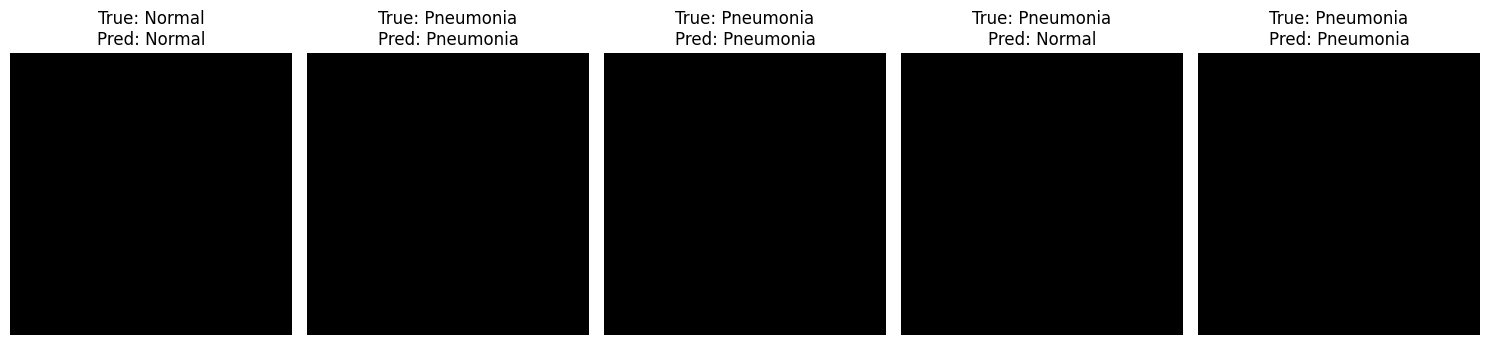

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

# Plot training and validation accuracy for both models
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_no_reg.history['accuracy'], label='Train (No Reg)')
plt.plot(history_no_reg.history['val_accuracy'], label='Validation (No Reg)')
plt.plot(history_with_reg.history['accuracy'], label='Train (With Reg)', linestyle='--')
plt.plot(history_with_reg.history['val_accuracy'], label='Validation (With Reg)', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

# Plot training and validation loss for both models
plt.subplot(1, 2, 2)
plt.plot(history_no_reg.history['loss'], label='Train Loss (No Reg)')
plt.plot(history_no_reg.history['val_loss'], label='Validation Loss (No Reg)')
plt.plot(history_with_reg.history['loss'], label='Train Loss (With Reg)', linestyle='--')
plt.plot(history_with_reg.history['val_loss'], label='Validation Loss (With Reg)', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions
predictions = model.predict(test_dataset)

# Convert predictions to binary labels
predicted_labels = (predictions > 0.7).astype("int32").flatten() # Adjust decision threshold as needed

# Extract true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate a classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Pneumonia']))

# Generate a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Visualize a few test samples with predictions
test_images, test_labels = next(iter(test_dataset))
test_images = test_images.numpy()
test_labels = test_labels.numpy()

# Select random samples
num_samples = 5
indices = random.sample(range(len(test_images)), num_samples)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(test_images[idx].astype("uint8"))
    true_label = "Pneumonia" if test_labels[idx] == 1 else "Normal"
    pred_label = "Pneumonia" if predicted_labels[idx] == 1 else "Normal"
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()
